<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/EfficientNet_b4_MVtecAD_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## trina/ test 나눠서 학습

In [1]:
'''
torch.hub : Pytorch Hub는 연구 재현성을 촉진하도록 설계된 사전 훈련 된 모델 저장소
nvidia_efficientnet_b4 사전 모델 가져옴
'''
# import torch
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
!pip install timm
import timm
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=88)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## 학습 코드
import warnings
warnings.filterwarnings('ignore')

import torch
from glob import glob
from tqdm import tqdm
import cv2
#import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
import gc
import pandas as pd
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from PIL import Image
# from efficientnet_pytorch import EfficientNet
# model_name = 'efficientnet-b0'  # b5

# image_size = EfficientNet.get_image_size(model_name)
# print(image_size)
# model = EfficientNet.from_pretrained(model_name, num_classes=88)

In [4]:
## 기본 설정
device = torch.device('cuda')
batch_size  = 32
random_seed = 1234
img_size = 224
random.seed(random_seed)
torch.manual_seed(random_seed)

## transforms 함수 정리
* transforms.ToPILImage() - csv 파일로 데이터셋을 받을 경우, PIL image로 바꿔준다.
* transforms.CenterCrop(size) - 가운데 부분을 size 크기로 자른다.
* transforms.Grayscale(num_output_channels=1) - grayscale로 변환한다.
* transforms.RandomAffine(degrees) - 랜덤으로 affine 변형을 한다.
* transforms.RandomCrop(size) -이미지를 랜덤으로 아무데나 잘라 size 크기로 출력한다.
* transforms.RandomResizedCrop(size) - 이미지 사이즈를 size로 변경한다
* transforms.Resize(size) - 이미지 사이즈를 size로 변경한다
* transforms.RandomRotation(degrees) 이미지를 랜덤으로 degrees 각도로 회전한다.
* transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)) - 이미지를 랜덤으로 변형한다.
* transforms.RandomVerticalFlip(p=0.5) - 이미지를 랜덤으로 수직으로 뒤집는다. p =0이면 뒤집지 않는다.
* transforms.RandomHorizontalFlip(p=0.5) - 이미지를 랜덤으로 수평으로 뒤집는다.
* transforms.ToTensor() - 이미지 데이터를 tensor로 바꿔준다.
* transforms.Normalize(mean, std, inplace=False) - 이미지를 정규화한다.

In [5]:
## 데이터 전처리 함수
# make dataset
#data_path = 'president/president_data'  # class 별 폴더로 나누어진 걸 가져와서 라벨도 달아준다
# train_dataset = datasets.ImageFolder(data_path,
#                                      transforms.Compose([
#                                      transforms.Resize((224, 224)),
#                                      transforms.RandomCrop(224),
#                                      transforms.RandomRotation(90, expand=True),
#                                      transforms.RandomVerticalFlip(),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])) # Normalize는 많은 이미지의 평균, 표준편차로 정함(보통 많이 하는 값이라고함)


### 이미지 전처리 함수 & 클래스
## 이미지  > 넘파이 배열로 변환
def img_load(path):
    img = cv2.imread(path)[:,:,::-1] # Return type:	numpy.ndarray / 기본적으로 BGR로 불러옴, RGB 변환함
    img = cv2.resize(img, (224, 224))
    return img

class Custom_dataset_1(Dataset): # 기본
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
        if self.mode == 'train':
          img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        if self.mode=='test':
          pass
        ## 레이블 > 원-핫 인코딩 하기 
        label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
        return img, label

class Custom_dataset_2(Dataset): # 변형
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
          img = Image.fromarray(img)
          #img = transforms.Resize((img_size, img_size))(img) # 처음 이미지 불러올때 resize 했으므로 생략
          #img = transforms.RandomCrop(img_size)(img)
          img = transforms.RandomRotation(90, expand=False)(img)
          img = transforms.RandomVerticalFlip()(img)
          img = transforms.RandomHorizontalFlip()(img)
          img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
          img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        if self.mode=='test':
          img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
        ## 레이블
        label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
        return img, label

class Custom_dataset_3(Dataset): # 기본이미지 + 변형이미지 (train 시 2배 증량됨)
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if self.mode=='train':
          if idx < 4277: # 변경 없는 이미지
            img = self.img_paths[idx]
            img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            label = self.labels[idx]
            return img, label

          else : # 랜덤 변경된 이미지 추가됨 
            img = self.img_paths[idx]
            img = Image.fromarray(img)
            #img = transforms.Resize((img_size, img_size))(img) # 처음 이미지 불러올때 resize 했으므로 생략
            #img = transforms.RandomCrop(img_size)(img)
            img = transforms.RandomRotation(90, expand=False)(img)
            img = transforms.RandomVerticalFlip()(img)
            img = transforms.RandomHorizontalFlip()(img)
            img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
            return img, label

        if self.mode=='test':
          img = self.img_paths[idx]
          img = transforms.ToTensor()(img)
          label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
          return img, label
            

In [6]:
### 이미지 로드 및 전처리
# 이미지 경로
train_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))
train_imgs = [img_load(m) for m in tqdm(train_png)]

#train_imgs = np.load('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/train_imgs_224.npy')
train_y = pd.read_csv("/content/drive/Othercomputers/내 MacBook Pro/open/train_df.csv")

train_labels = train_y["label"] # 레이블순서는 이미지 파일 순서대로임

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))} # 오름차순으로 레이블별로 숫자 부여(0부터 시작)

train_labels = [label_unique[k] for k in train_labels]

## 이미지 증량 시만 사용
train_imgs = train_imgs + train_imgs
train_labels = train_labels+train_labels

train_dataset = Custom_dataset_3(np.array(train_imgs), np.array(train_labels), mode='train')

### 데이터셋 분리 > 층화추출 & 테스터 데이터 비율 : 0.3, 시드 : 1234, 셔플 = True(default)
train_idx, vaild_idx = train_test_split(list(range(len(train_dataset))), stratify=train_labels, test_size=0.3, random_state=random_seed)

datasets = {} # 데이터셋을 담을 딕셔너리
datasets['train'] = Subset(train_dataset, train_idx)
datasets['vaild']  = Subset(train_dataset, vaild_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=0)
dataloaders['vaild']  = torch.utils.data.DataLoader(datasets['vaild'],
                                                    batch_size=batch_size, shuffle=False,
                                                    num_workers=0)
'''
데이터 변형 코드를 추가한 후 아래 오류코드가 나와
Caught TypeError in DataLoader worker process 0
DataLoader > num_workers 를 4 -> 0 로 낮춤
'''

batch_num['train'], batch_num['vaild'] = len(dataloaders['train']), len(dataloaders['vaild'])
print('batch_size : %d,  train/vaild(데이터셋개수/배치사이즈) : %d / %d' % (batch_size, batch_num['train'],batch_num['vaild']))

100%|██████████| 4277/4277 [02:08<00:00, 33.19it/s]


batch_size : 32,  train/vaild(데이터셋개수/배치사이즈) : 188 / 81


In [ ]:
# 참고 블로그 : https://keep-steady.tistory.com/35
import gc
gc.collect()
torch.cuda.empty_cache()

### f1 스코어 함수 
def score_function(real, pred): # 라이브러리 > sklearn.metrics 
    score = f1_score(real, pred, average="macro")
    return score

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = [], [], [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))# - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'vaild']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # device = torch.device('cuda')
                labels = labels.to(device) # device = torch.device('cuda')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            f1 = score_function(labels.cpu().data, preds.cpu()) # score_function or f1_score

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(f1)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                valid_f1.append(f1)

            print('{} Loss: {:.5f} Acc: {:.5f} macro-f1: {:.5f}'.format(phase, epoch_loss, epoch_acc, f1))
           
            # deep copy the model(최적모델 저장)
            if phase == 'vaild' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        # 한 에포크마다 실행 시간 출력하기(누적 시간으로 출력됨)
        time_elapsed = time.time() - since
        print('each epochs training time : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('\n')

        # 한 에포크마다 필요없는 메모리 지우기 : 지우기 효과는 아직 확인 못해봄
        try:      
          gc.collect() # cpu 비움
          torch.cuda.empty_cache() # gpu 비움
        except:
          pass
          
    ## 학습 마무리 후
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    '''
    한 에포크 마다 저장된 최적의 모델 가중치로 조정 후 다음 에포크가 돌아감
    '''
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1

# 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

# 사전학습된 가중치와 모델을 가져와 데이터셋으로 추가 모델 학습
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/100
----------
train Loss: 1.07210 Acc: 81.59345 macro-f1: 0.50000
vaild Loss: 0.55124 Acc: 86.52123 macro-f1: 0.71429
==> best model saved - 0 / 86.5
each epochs training time : 1m 13s


Epoch 1/100
----------
train Loss: 0.47859 Acc: 88.39151 macro-f1: 0.50000
vaild Loss: 0.40086 Acc: 89.79353 macro-f1: 1.00000
==> best model saved - 1 / 89.8
each epochs training time : 2m 26s


Epoch 2/100
----------
train Loss: 0.33783 Acc: 91.16419 macro-f1: 0.20000
vaild Loss: 0.32742 Acc: 90.96221 macro-f1: 1.00000
==> best model saved - 2 / 91.0
each epochs training time : 3m 39s


Epoch 3/100
----------
train Loss: 0.26271 Acc: 92.75096 macro-f1: 0.50000
vaild Loss: 0.28051 Acc: 92.24776 macro-f1: 1.00000
==> best model saved - 3 / 92.2
each epochs training time : 4m 52s


Epoch 4/100
----------
train Loss: 0.20047 Acc: 94.12059 macro-f1: 0.50000
vaild Loss: 0.22097 Acc: 93.33853 macro-f1: 1.00000
==> best model saved - 4 / 93.3
each epochs training time : 6m 4s


Epoch 5/100
---------

best model : 55 - 97 / 0.2


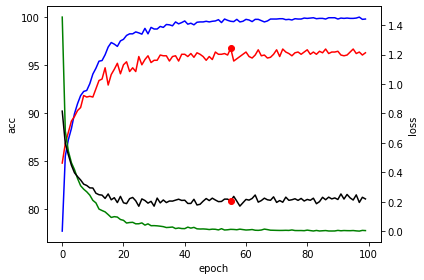

In [11]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [14]:
# ## 학습 결과 검수
# def test_and_visualize_model(model, phase = 'test', num_images=4):
#     # phase = 'train', 'valid', 'test'
    
#     was_training = model.training
#     model.eval()
#     fig = plt.figure()
    
#     running_loss, running_corrects, num_cnt = 0.0, 0, 0

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders[phase]):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)  # batch의 평균 loss 출력

#             running_loss    += loss.item() * inputs.size(0)
#             running_corrects+= torch.sum(preds == labels.data)
#             num_cnt += inputs.size(0)  # batch size

#     #         if i == 2: break

#         test_loss = running_loss / num_cnt
#         test_acc  = running_corrects.double() / num_cnt       
#         print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

#     # 예시 그림 plot
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders[phase]):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)        

#             # 예시 그림 plot
#             for j in range(1, num_images+1):
#                 ax = plt.subplot(num_images//2, 2, j)
#                 ax.axis('off')
#                 ax.set_title('%s : %s -> %s'%(
#                     'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
#                     class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
#                 imshow(inputs.cpu().data[j])          
#             if i == 0 : break


#     model.train(mode=was_training);  # 다시 train모드로
    
#     ## TEST!
#     test_and_visualize_model(model, phase = 'test')

## 모델 추론

In [12]:
## 모델을 평가 모드로 변경하고 test 데이터 분류
test_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/test/*.png'))
test_imgs = [img_load(n) for n in tqdm(test_png)]
test_dataset = Custom_dataset_3(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

100%|██████████| 2154/2154 [01:07<00:00, 32.05it/s]


In [13]:
## 숫자로된 레이블을 문자열 레이블로 변경
label_decoder = {value:key for key, value in label_unique.items()}
f_result = [label_decoder[result] for result in f_pred]

In [14]:
from datetime import datetime as dt 
today = dt.today().strftime('%Y-%m-%d')
version = f'efficientNet_b4_by_timm_imageTransfroms_ver_{today}'
submission = pd.read_csv(f"/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/sample_submission.csv")

## 시각적 확인을 위해 문자열 레이블로 이루어진 된 label 필드 생성
submission["label"] = f_result
display(submission)
submission.to_csv(f"/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/sample_submission_{version}.csv", index = False)

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good
